In [1]:
# coding: utf-8
#---------------------------------------------------------------------
'''
Neural Machine Translation - Translation experiments
    Training, evaluation and prediction functions
'''
#---------------------------------------------------------------------

# In[ ]:

import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from tqdm import tqdm
import sys
import os
from collections import Counter
import math
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time
import matplotlib.gridspec as gridspec
import importlib
# %matplotlib inline

# In[ ]:

#---------------------------------------------------------------------
# Load configuration
#---------------------------------------------------------------------
from nmt_config import *

# In[ ]:
#---------------------------------------------------------------------
# Load encoder decoder model definition
#---------------------------------------------------------------------
from enc_dec import *

# In[ ]:

xp = cuda.cupy if gpuid >= 0 else np

# In[ ]:
#---------------------------------------------------------------------
# Load dataset
#---------------------------------------------------------------------
w2i = pickle.load(open(w2i_path, "rb"))
i2w = pickle.load(open(i2w_path, "rb"))
vocab = pickle.load(open(vocab_path, "rb"))
vocab_size_en = min(len(i2w["en"]), max_vocab_size["en"])
vocab_size_fr = min(len(i2w["fr"]), max_vocab_size["fr"])
print("vocab size, en={0:d}, fr={1:d}".format(vocab_size_en, vocab_size_fr))
print("{0:s}".format("-"*50))
#---------------------------------------------------------------------

# In[ ]:
#---------------------------------------------------------------------
# Set up model
#---------------------------------------------------------------------
model = EncoderDecoder(vocab_size_fr, vocab_size_en,
                       num_layers_enc, num_layers_dec,
                       hidden_units, gpuid, attn=use_attn)
if gpuid >= 0:
    cuda.get_device(gpuid).use()
    model.to_gpu()

optimizer = optimizers.Adam()
optimizer.setup(model)

'''
___QUESTION-1-DESCRIBE-F-START___

- Describe what the following line of code does
'''
optimizer.add_hook(chainer.optimizer.GradientClipping(threshold=5))
'''___QUESTION-1-DESCRIBE-F-END___'''

# In[ ]:

#---------------------------------------------------------------------
print("Training progress will be logged in:\n\t{0:s}".format(log_train_fil_name))
print("{0:s}".format("-"*50))
print("Trained model will be saved as:\n\t{0:s}".format(model_fil))
print("{0:s}".format("-"*50))
#---------------------------------------------------------------------



Japanese English dataset configuration
vocab size, en=3713, fr=3949
--------------------------------------------------
Training progress will be logged in:
	model/train_10000sen_1-1layers_100units_ja_en_exp1_NO_ATTN.log
--------------------------------------------------
Trained model will be saved as:
	model/seq2seq_10000sen_1-1layers_100units_ja_en_exp1_NO_ATTN.model
--------------------------------------------------


In [2]:

length_fr=[]
length_en=[]
with open(text_fname["fr"], "r") as fr_file, open(text_fname["en"], "r") as en_file:
    for i, (line_fr, line_en) in enumerate(zip(fr_file, en_file), start=1):
        fr_sent = line_fr.strip()
        en_sent = line_en.strip()
        length_fr.append(len(fr_sent))
        length_en.append(len(en_sent))

print("{0:s}".format("-"*50))
print(length_fr)
print(length_en)
print("{0:s}".format("-"*50))


--------------------------------------------------
[25, 36, 51, 25, 39, 29, 31, 29, 22, 26, 26, 20, 26, 31, 47, 27, 28, 27, 17, 33, 31, 21, 32, 30, 30, 26, 27, 19, 37, 23, 29, 24, 27, 55, 24, 34, 21, 30, 20, 24, 21, 22, 41, 23, 31, 35, 35, 45, 37, 35, 30, 21, 33, 27, 20, 26, 30, 37, 41, 19, 27, 19, 30, 33, 27, 27, 20, 28, 19, 33, 33, 28, 68, 31, 45, 43, 20, 27, 25, 24, 27, 27, 27, 36, 34, 39, 23, 38, 20, 38, 43, 22, 48, 21, 24, 66, 53, 54, 20, 17, 47, 23, 25, 20, 30, 32, 27, 30, 24, 37, 53, 40, 44, 25, 23, 50, 24, 33, 19, 24, 24, 18, 43, 21, 12, 26, 26, 20, 34, 29, 23, 33, 22, 48, 26, 75, 45, 31, 16, 22, 59, 30, 27, 56, 25, 22, 30, 51, 37, 19, 25, 22, 50, 28, 37, 19, 43, 30, 14, 25, 39, 24, 20, 17, 50, 54, 34, 30, 30, 33, 19, 23, 51, 35, 32, 16, 37, 16, 30, 43, 25, 29, 40, 72, 40, 26, 16, 21, 20, 30, 29, 57, 37, 34, 36, 14, 22, 40, 16, 24, 52, 24, 24, 24, 26, 35, 26, 55, 13, 34, 28, 30, 40, 38, 36, 25, 28, 27, 32, 28, 18, 40, 49, 67, 23, 26, 23, 16, 29, 40, 26, 9, 20, 20, 30, 23, 40, 2

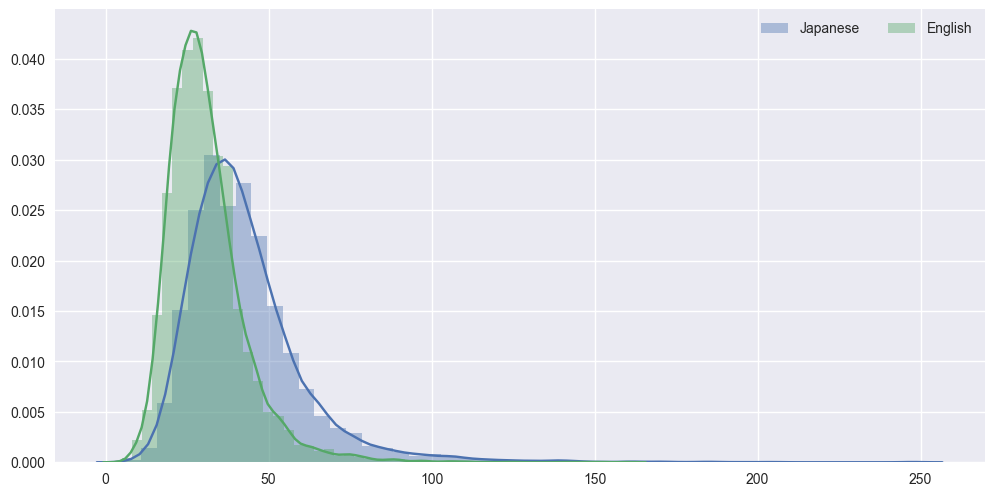

In [49]:
import seaborn as sns  
import numpy as np  
from numpy.random import randn  
import matplotlib as mpl  
import matplotlib.pyplot as plt  
from scipy import stats  
%matplotlib inline
plt.figure(figsize=(12,6),dpi=100)
x = length_fr 
y = length_en 
fig1=sns.distplot(y)
fig2=sns.distplot(x)
label = ["Japanese", "English"]    
plt.legend(label, loc = 0, ncol = 2)  
plt.savefig("a.pdf")
# fig1, ax1 = plt.subplots()
# fig2, ax2 = plt.subplots()
# fig1.set_size_inches(8, 6)
# ax1.plot(length_fr)
# ax2.plot(length_en)
# # ax1.set_xlim(0, (n_epochs * train_size))
# # ax1.set_xlabel("iteration", size=24)
# # ax1.set_ylabel("loss", color="r", size=24)
# # for tlbl in ax1.get_yticklabels():
# #     tlbl.set_color("r")
# #     tlbl.set_size(16)
# # for tlbl in ax1.get_xticklabels():
# #     tlbl.set_size(16)
# #     tlbl.set_rotation(45)
# # plt.legend(['training loss'], bbox_to_anchor=(1.48, 1.05), framealpha=0, fontsize=20)
# plt.title("Training loss per iteration", size=20)
# plt.tight_layout()

In [4]:

num_tokens_en = 0
num_tokens_fr = 0

with open(text_fname["fr"], "r") as fr_file, open(text_fname["en"], "r") as en_file:
    fr=fr_file.read()
    en=en_file.read()
    num_tokens_fr =len(fr)
    num_tokens_en =len(en)
print("{0:s}".format("-"*50))
print("{0:14s} | {1:d}".format("# char in en", num_tokens_en))
print("{0:14s} | {1:d}".format("# char in fr", num_tokens_fr))
print("{0:s}".format("-"*50))

--------------------------------------------------
# char in en   | 460145
# char in fr   | 335739
--------------------------------------------------


In [5]:
num_words_en = 0
num_words_fr = 0
with open(text_fname["fr"], "rb") as fr_file, open(text_fname["en"], "rb") as en_file:
    for i, (line_fr, line_en) in enumerate(zip(fr_file, en_file), start=1):
        fr_sent = line_fr.strip().split()
        en_sent = line_en.strip().split()
        fr_ids = [w2i["fr"].get(w, UNK_ID) for w in fr_sent]
        en_ids = [w2i["en"].get(w, UNK_ID) for w in en_sent]
        num_words_en += len(en_ids)
        num_words_fr += len(fr_ids)
print("{0:s}".format("-"*50))
print("{0:14s} | {1:d}".format("# words in en", num_words_en))
print("{0:14s} | {1:d}".format("# words in fr", num_words_fr))

print("{0:s}".format("-"*50))

--------------------------------------------------
# words in en  | 97643
# words in fr  | 143581
--------------------------------------------------


In [6]:
chars_en = {}
chars_fr ={}
with open(text_fname["fr"], "r") as fr_file, open(text_fname["en"], "rb") as en_file:
    fr=fr_file.read()
    en=en_file.read()
for c in fr:
    if c not in chars_en:
        chars_en[c] = 1
    else:
        chars_en[c] += 1
for c in en:
    if c not in chars_fr:
        chars_fr[c] = 1
    else:
        chars_fr[c] += 1
        
print("{0:s}".format("-"*50))
print("{0:14s} | {1:d}".format("# type char in en", len(chars_en)))
print("{0:14s} | {1:d}".format("# type char in fr", len(chars_fr)))
print("{0:s}".format("-"*50))

--------------------------------------------------
# type char in en | 2142
# type char in fr | 60
--------------------------------------------------


In [7]:
chars_en = {}
chars_fr = {}
with open(text_fname["fr"], "rb") as fr_file, open(text_fname["en"], "rb") as en_file:
    for i, (line_fr, line_en) in enumerate(zip(fr_file, en_file), start=1):
        fr_sent = line_fr.strip().split()
        en_sent = line_en.strip().split()
        for c in fr_sent:
            if c not in chars_fr:
                chars_fr[c] = 1
            else:
                chars_fr[c] += 1
        for c in en_sent:
            if c not in chars_en:
                chars_en[c] = 1
            else:
                chars_en[c] += 1
print("{0:s}".format("-"*50))
print("{0:14s} | {1:d}".format("# type words in en", len(chars_en)))
print("{0:14s} | {1:d}".format("# type words in fr", len(chars_fr)))
print("{0:s}".format("-"*50))



--------------------------------------------------
# type words in en | 7211
# type words in fr | 8252
--------------------------------------------------


In [8]:
num_UNK_en = 0
num_UNK_fr = 0

with open(text_fname["fr"], "rb") as fr_file, open(text_fname["en"], "rb") as en_file:
    for key in chars_en:
        if chars_en.get(key)==1:
            num_UNK_en+=1
    for key in chars_fr:
        if chars_fr.get(key)==1:
            num_UNK_fr+=1
print("{0:s}".format("-"*50))
print("{0:14s} | {1:d}".format("# num UNK in en", num_UNK_en))
print("{0:14s} | {1:d}".format("# num UNK in fr", num_UNK_fr))
print("{0:s}".format("-"*50))



--------------------------------------------------
# num UNK in en | 3384
# num UNK in fr | 4172
--------------------------------------------------


In [15]:
class Solution(object):
    def twoSum(self, nums, target):
        if len(nums<=1):
            return False
        else:
            a={}
            for i in range (len(nums)):
                if nums[i] in a:
                    return [a{nums[i]},i]
                else:
                    a{target-nums[i]}=i
          
        """
        :type nums: List[int]
        :type target: int
        :rtype: List[int]
        """
        

SyntaxError: invalid syntax (<ipython-input-15-3dc991735f4c>, line 9)

In [9]:
print(fr_ids)

[2157, 5, 3, 14, 1340, 6, 11, 76, 6, 4]


In [14]:
%run nmt_translate.py

_ = predict(s=0, num=1, sample=True)

vocab size, en=3713, fr=3949
--------------------------------------------------
Training progress will be logged in:
	model/train_10000sen_1-1layers_100units_ja_en_exp1_NO_ATTN.log
--------------------------------------------------
Trained model will be saved as:
	model/seq2seq_10000sen_1-1layers_100units_ja_en_exp1_NO_ATTN.model
--------------------------------------------------
Existing model found
--------------------------------------------------
loading model ...
finished loading: model/seq2seq_10000sen_1-1layers_100units_ja_en_exp1_NO_ATTN.model
--------------------------------------------------
English predictions, s=0, num=1:
--------------------------------------------------
Src | ステーキ は 中位 で 焼 い て くださ い 。                                                       
Ref | i like my steak medium .                                                        
Hyp | i like my steak medium . _EOS                                                   
----------------------------------------------